In [1]:
import os
import shutil
import random
import numpy as np

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sn
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib.path import Path
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

from keras.optimizers import Adam

from dltk.io.augmentation import *

from src.bi_classifier3D import Biclassifier3D

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Data loading and preprocessing

In [2]:
# dirpath = "./data"
# if os.path.exists(dirpath) and os.path.isdir(dirpath):
#     shutil.rmtree(dirpath)

In [3]:
from src.arrange_dataset import arrange_dataset

data_dir = arrange_dataset() 
print(data_dir)

Dataset arranged in ./data
./data


In [4]:
from src.data_loader3D import NiiSequence, dataGenerator
from sklearn.model_selection import train_test_split

batch_size = 16
nb_classes = 4

train_set, train_labels = dataGenerator(data_dir, mode="train", nb_classes=nb_classes)
test_set, test_labels = dataGenerator(data_dir, mode="val", nb_classes=nb_classes)
train_set, val_set, train_labels, val_labels = train_test_split(train_set, train_labels, test_size=0.2, random_state=42, shuffle=True)

print("Train set size: ", len(train_set))
print("Validation set size: ", len(val_set))
print("Test set size: ", len(test_set))

Train set size:  457
Validation set size:  115
Test set size:  146


In [5]:
train_sequence = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False)
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['gaussian_offset', 'gaussian_noise', 'shiftIntensity', 'adjustContrast'])
val_sequence = NiiSequence(val_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False)
test_sequence = NiiSequence(test_set, batch_size, nb_classes=nb_classes, mode="HC", shuffle=False)

print("Shape of one MRI element:", train_sequence[0][0].shape)
print("Train label example after loading:", train_sequence[0][1])

print("Shape of one batch:", test_sequence[0][0].shape)
print("Test label example after loading:", test_sequence[0][1])

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
Shape of one batch: (16, 40, 40, 80, 1)
Test label example after loading: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [6]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (15, 40, 40, 80, 1)
Train label example after loading: (15, 4)


Scan Visualization

228


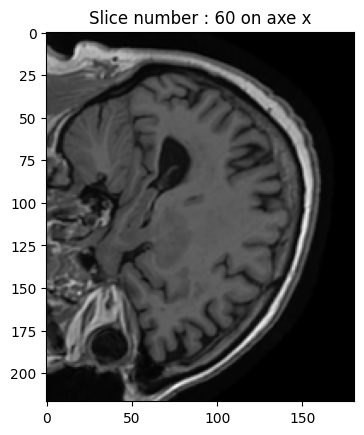

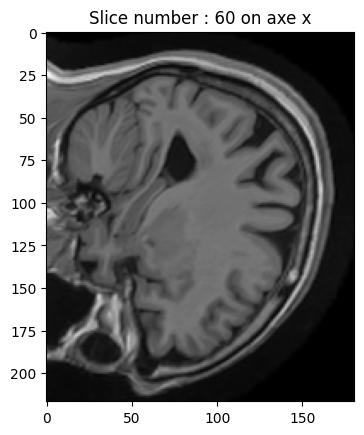

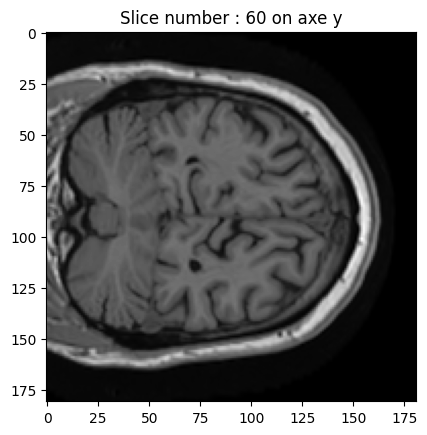

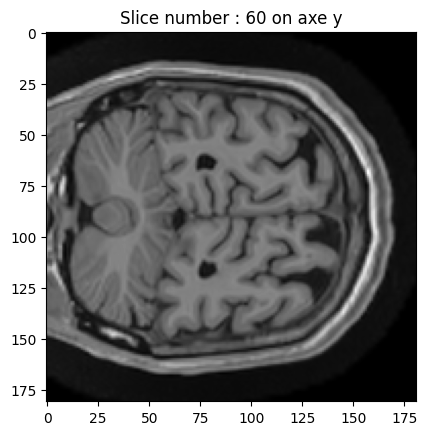

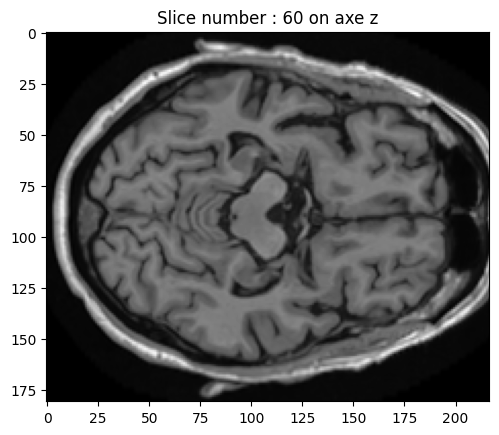

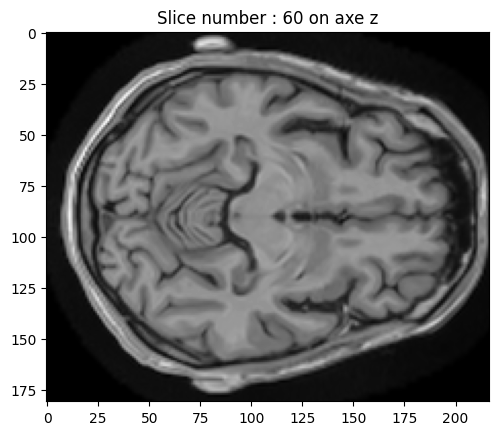

In [7]:
# MRI images are composed by many slices, build a montage of the them
def show_2D(irm, slice, axe):
    if axe == "x":
        plt.imshow(irm[slice,:,:], cmap="gray")
    elif axe == "y":
        plt.imshow(irm[:,slice,:], cmap="gray")
    elif axe == "z":
        plt.imshow(irm[:,:,slice], cmap="gray")
    plt.title("Slice number : " + str(slice) + " on axe " + axe)
    plt.show()

firstAug = int(train_set.__len__()/2)
img = nib.load(train_set[0])
print(firstAug)
img2 = nib.load(train_set[firstAug])

show_2D(img.get_fdata(), 60, "x")
show_2D(img2.get_fdata(), 60, "x")

show_2D(img.get_fdata(), 60, "y")
show_2D(img2.get_fdata(), 60, "y")

show_2D(img.get_fdata(), 60, "z")
show_2D(img2.get_fdata(), 60, "z")

Imbalanced Data

{'CN': 227, 'SMCI': 129, 'PMCI': 171, 'AD': 191}


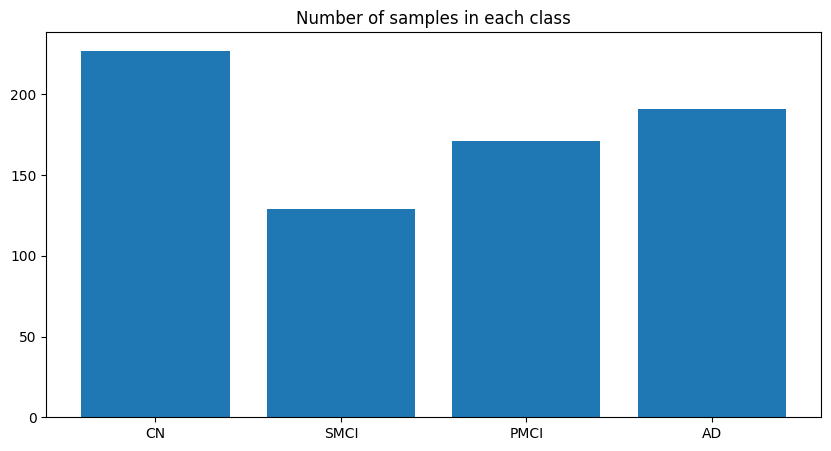

In [8]:
## Calculate number of samples in each class.
input_folder = 'lib'
class_counts = dict()
class_names = ["CN", "SMCI", "PMCI", "AD"]
if nb_classes == 2:
    class_names = ["CN", "AD"]
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

print(class_counts)

# plot the number of samples in each class
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of samples in each class')
plt.show()

# 3D Convolutional Neural Network without data augmentation

In [9]:
from src.bi_classifier3D import Biclassifier3D

input_shape = (train_sequence[0][0].shape[1], train_sequence[0][0].shape[2], train_sequence[0][0].shape[3], train_sequence[0][0].shape[4])
print("Input shape:", input_shape)
bicl = Biclassifier3D(input_shape, n_classes=nb_classes, n_filters=8, kernel_size=3, activation='relu', dropout=0.4)
model = bicl.build_model()
model.summary()
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy'],
)

Input shape: (40, 40, 80, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization (BatchN  (None, 40, 40, 80, 8)    32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_1 (Activation)   (None, 40, 40, 80, 8)     0         
                                

/home/priscilla/.local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model training

In [10]:
# checkpoint
filepath="classifier3D-imb-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

callbacks_list = [checkpoint, early_stop, reduce_lr]

In [11]:
model.fit(
    train_sequence,
    validation_data=val_sequence,
    validation_steps=len(val_set) // batch_size,
    callbacks=callbacks_list,
    epochs=10,
)

Epoch 1/10
29/29 [==============================] - ETA: 0s - loss: 1.4434 - accuracy: 0.2998
Epoch 1: val_accuracy improved from -inf to 0.27679, saving model to classifier3D_test_lol-01-0.28.hdf5
29/29 [==============================] - 95s 3s/step - loss: 1.4434 - accuracy: 0.2998 - val_loss: 1.3619 - val_accuracy: 0.2768 - lr: 1.0000e-04
Epoch 2/10
29/29 [==============================] - ETA: 0s - loss: 1.2944 - accuracy: 0.4376
Epoch 2: val_accuracy improved from 0.27679 to 0.35714, saving model to classifier3D_test_lol-02-0.36.hdf5
29/29 [==============================] - 96s 3s/step - loss: 1.2944 - accuracy: 0.4376 - val_loss: 1.3349 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 1.2199 - accuracy: 0.4092
Epoch 3: val_accuracy did not improve from 0.35714
29/29 [==============================] - 92s 3s/step - loss: 1.2199 - accuracy: 0.4092 - val_loss: 1.3588 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 4/10
29/29 [

Visualizing Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


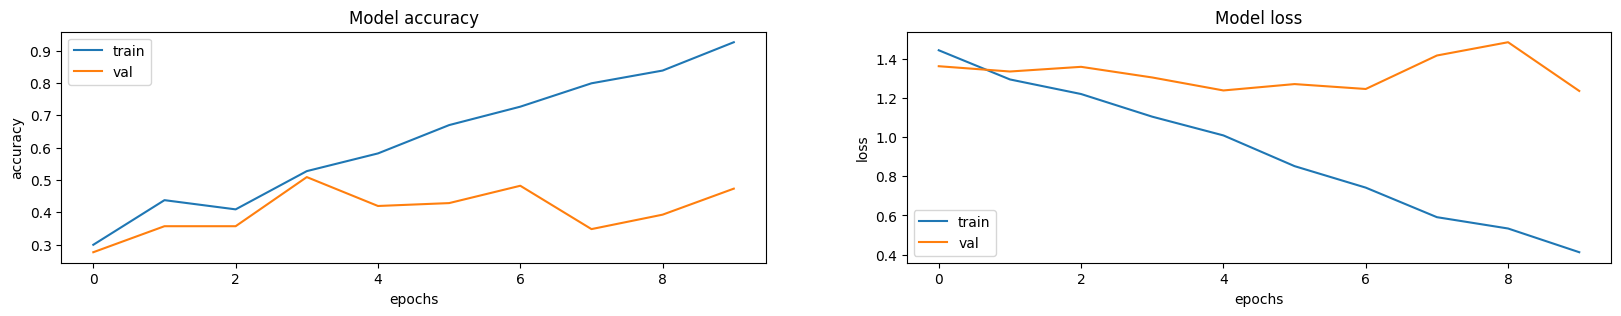

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

print(model.history.history.keys())
for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history[f'val_{metric}'])
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

Model Evaluation

In [13]:
# test_sequence = NiiSequence(test_set, batch_size, nb_classes=nb_classes, mode="HC", shuffle=False)
model.evaluate(test_sequence, verbose=1)

10/10 [==============================] - 23s 2s/step - loss: 1.3215 - accuracy: 0.4521


[1.3214976787567139, 0.45205479860305786]

In [14]:
y = model.predict(test_sequence)

10/10 [==============================] - 23s 2s/step


In [15]:
y_pred = y.argmax(axis=1)
y_test = np.array(test_labels)
print(y_pred)
print(y_test)

[2 1 2 0 0 0 0 0 0 2 0 1 0 0 1 0 0 3 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 3 3 1 0 0 0 3 0 0 3 2 0 0 0 0 0 0 0 0 2 3 3 2 0 0 2 3 2
 3 3 2 3 3 1 2 3 3 2 2 3 3 3 2 3 3 2 3 3 0 0 2 3 3 2 0 2 1 3 0 3 2 3 3 3 2
 2 1 3 0 2 0 0 1 3 3 1 0 2 3 0 3 3 3 3 0 3 0 3 3 3 0 2 0 3 2 2 3 3 3 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [12]:
def calcul_metrics(y_pred,y_true):
    print("Precision", precision_score(y_true, y_pred, average='macro'))
    print("Recall", recall_score(y_true, y_pred, average='macro'))
    print("f1_score", f1_score(y_true, y_pred, average='macro'))

In [34]:
calcul_metrics(y_pred,y_test)

Precision 0.36952861952861954
Recall 0.4001990762860328
f1_score 0.37687586219709446


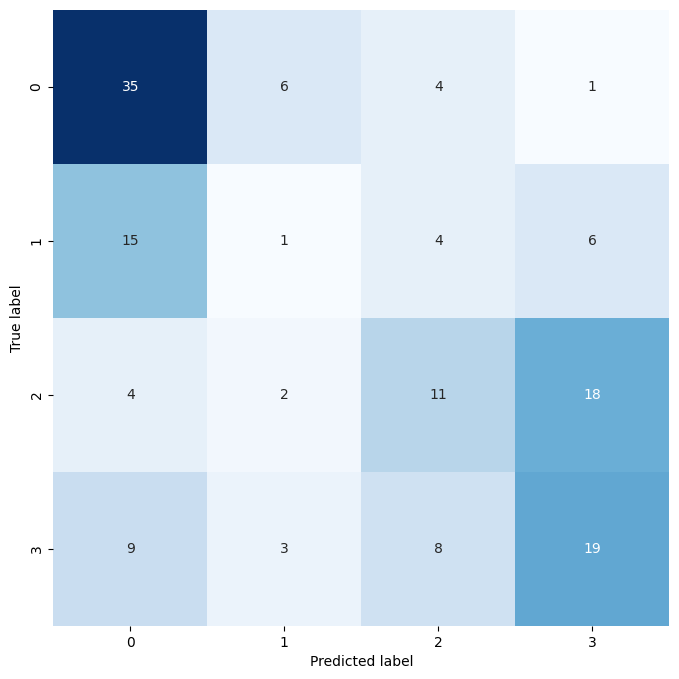

In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_ = cm / cm.astype(float).sum(axis=1) * 100
plt.figure(figsize=(8, 8))
sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

29/29 [==============================] - 68s 2s/step
Precision 0.9426798174986581
Recall 0.9108373602357869
f1_score 0.9215180653049808


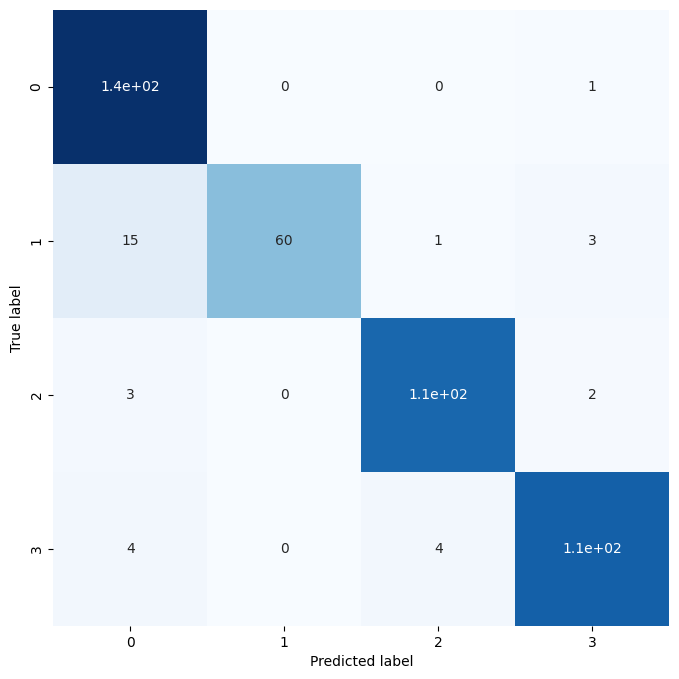

In [37]:
y = model.predict(train_sequence)
y_pred = y.argmax(axis=1)
y_train = np.array(train_labels)

calcul_metrics(y_pred,y_train)

cm = confusion_matrix(y_train, y_pred)
cm_ = cm / cm.astype(float).sum(axis=1) * 100
plt.figure(figsize=(8, 8))
sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Neural network with data augmentation

In [13]:
def fonc_training(train_sequence_aug):
    input_shape = (train_sequence[0][0].shape[1], train_sequence[0][0].shape[2], train_sequence[0][0].shape[3], train_sequence[0][0].shape[4])
    print("Input shape:", input_shape)
    bicl = Biclassifier3D(input_shape, n_classes=nb_classes, n_filters=8, kernel_size=3, activation='relu', dropout=0.4)
    model = bicl.build_model()
    model.summary()
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy'],
    )
    # checkpoint
    filepath="classifcier3D-imb-dataAug-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)
    callbacks_list = [checkpoint, early_stop]
    
    model.fit(
        train_sequence_aug,
        validation_data=val_sequence,
        validation_steps=len(val_set) // batch_size,
        callbacks=callbacks_list,
        epochs=10,
    )
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()
    
    print(model.history.history.keys())
    for i, metric in enumerate(['accuracy', 'loss']):
        ax[i].plot(model.history.history[metric])
        ax[i].plot(model.history.history[f'val_{metric}'])
        ax[i].set_title(f'Model {metric}')
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(metric)
        ax[i].legend(['train', 'val'])

    return model

In [14]:
def fonc_eval(model):
    model.evaluate(test_sequence, verbose=1)
    
    y = model.predict(test_sequence)
    y_pred = y.argmax(axis=1)
    y_test = np.array(test_labels)
    
    calcul_metrics(y_pred,y_test)
    
    cm = confusion_matrix(y_test, y_pred)
    cm_ = cm / cm.astype(float).sum(axis=1) * 100
    plt.figure(figsize=(8, 8))
    sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [15]:
def fonc_predict_train(model):
    y = model.predict(train_sequence)
    y_pred = y.argmax(axis=1)
    y_train = np.array(train_labels)
    
    calcul_metrics(y_pred,y_train)
    
    cm = confusion_matrix(y_train, y_pred)
    cm_ = cm / cm.astype(float).sum(axis=1) * 100
    plt.figure(figsize=(8, 8))
    sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

### Gaussian offset

In [41]:
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['gaussian_offset'])

In [42]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: (16, 4)


Input shape: (40, 40, 80, 1)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_4 (Conv3D)           (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization_1 (Batc  (None, 40, 40, 80, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_5 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_6 (Activation)   (None, 40, 40, 80, 8)     0         
                              

/home/priscilla/.local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/10
58/58 [==============================] - ETA: 0s - loss: 2.1603 - accuracy: 0.2779
Epoch 1: val_accuracy improved from -inf to 0.34821, saving model to classifcier3D-imb-dataAug-01-0.35.hdf5
58/58 [==============================] - 88s 2s/step - loss: 2.1603 - accuracy: 0.2779 - val_loss: 1.3736 - val_accuracy: 0.3482
Epoch 2/10
58/58 [==============================] - ETA: 0s - loss: 1.3776 - accuracy: 0.2779
Epoch 2: val_accuracy did not improve from 0.34821
58/58 [==============================] - 94s 2s/step - loss: 1.3776 - accuracy: 0.2779 - val_loss: 1.3666 - val_accuracy: 0.3482
Epoch 3/10
58/58 [==============================] - ETA: 0s - loss: 1.3637 - accuracy: 0.3239
Epoch 3: val_accuracy did not improve from 0.34821
58/58 [==============================] - 93s 2s/step - loss: 1.3637 - accuracy: 0.3239 - val_loss: 1.3572 - val_accuracy: 0.3482
Epoch 4/10
58/58 [==============================] - ETA: 0s - loss: 1.3080 - accuracy: 0.3884
Epoch 4: val_accuracy impro

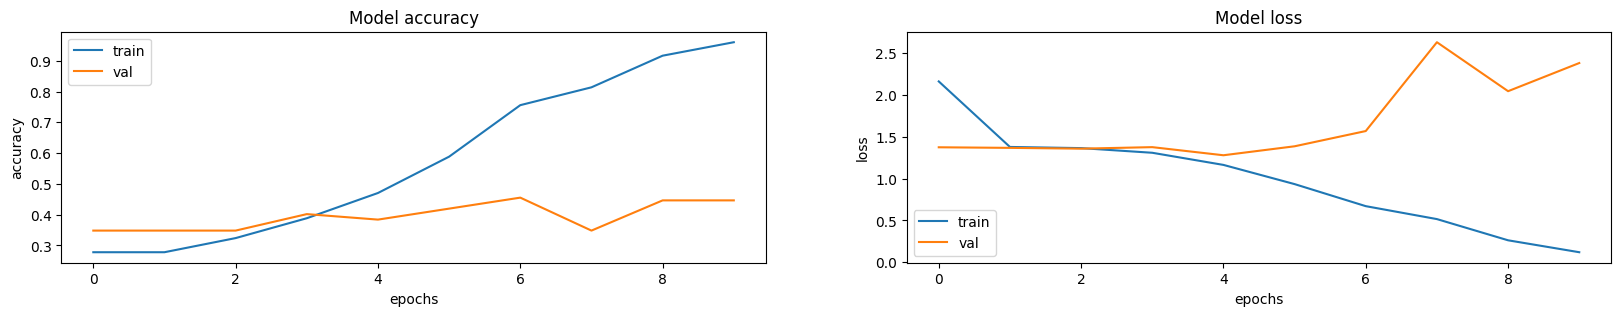

In [43]:
model =fonc_training(train_sequence_aug)

10/10 [==============================] - 21s 2s/step
Precision 0.39600752508361203
Recall 0.3937171524128046
f1_score 0.37929173016180484


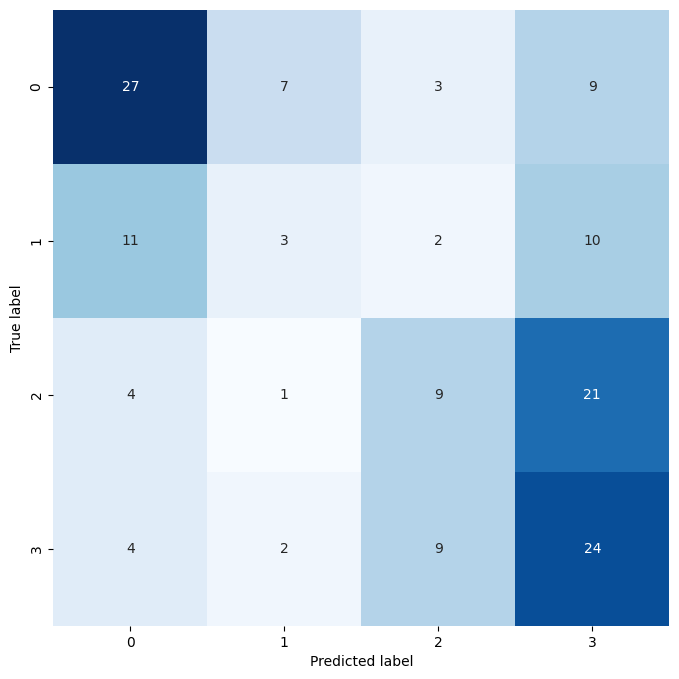

In [44]:
fonc_eval(model)

29/29 [==============================] - 72s 2s/step
Precision 0.9959677419354839
Recall 0.9936708860759493
f1_score 0.9947623514696685


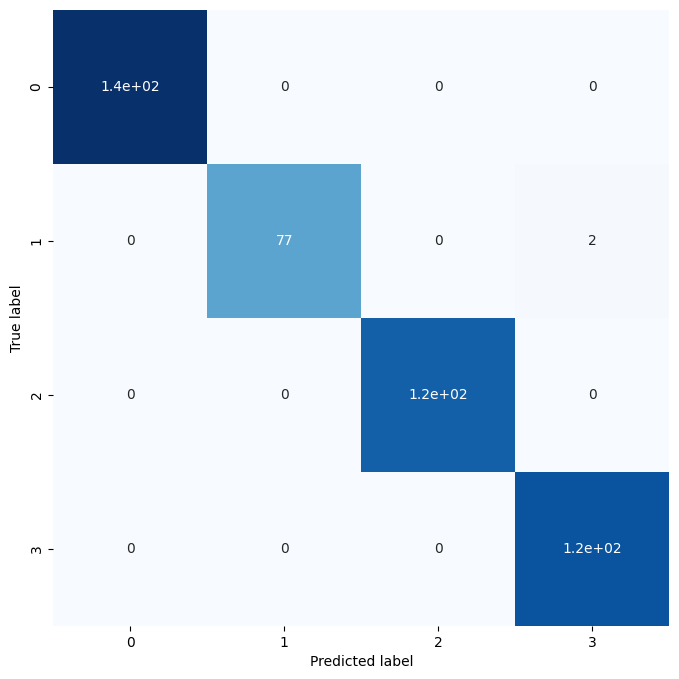

In [45]:
fonc_predict_train(model)

### Gaussian noise

In [46]:
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['gaussian_noise'])

In [47]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: (16, 4)


Input shape: (40, 40, 80, 1)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_8 (Conv3D)           (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization_2 (Batc  (None, 40, 40, 80, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_9 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_11 (Activation)  (None, 40, 40, 80, 8)     0         
                              

/home/priscilla/.local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/10
58/58 [==============================] - ETA: 0s - loss: 1.9708 - accuracy: 0.2702
Epoch 1: val_accuracy improved from -inf to 0.34821, saving model to classifcier3D-imb-dataAug-01-0.35.hdf5
58/58 [==============================] - 107s 2s/step - loss: 1.9708 - accuracy: 0.2702 - val_loss: 1.3772 - val_accuracy: 0.3482
Epoch 2/10
58/58 [==============================] - ETA: 0s - loss: 1.3665 - accuracy: 0.2987
Epoch 2: val_accuracy did not improve from 0.34821
58/58 [==============================] - 98s 2s/step - loss: 1.3665 - accuracy: 0.2987 - val_loss: 1.3687 - val_accuracy: 0.2589
Epoch 3/10
58/58 [==============================] - ETA: 0s - loss: 1.3434 - accuracy: 0.3632
Epoch 3: val_accuracy improved from 0.34821 to 0.46429, saving model to classifcier3D-imb-dataAug-03-0.46.hdf5
58/58 [==============================] - 92s 2s/step - loss: 1.3434 - accuracy: 0.3632 - val_loss: 1.2885 - val_accuracy: 0.4643
Epoch 4/10
58/58 [==============================] - ETA: 0s 

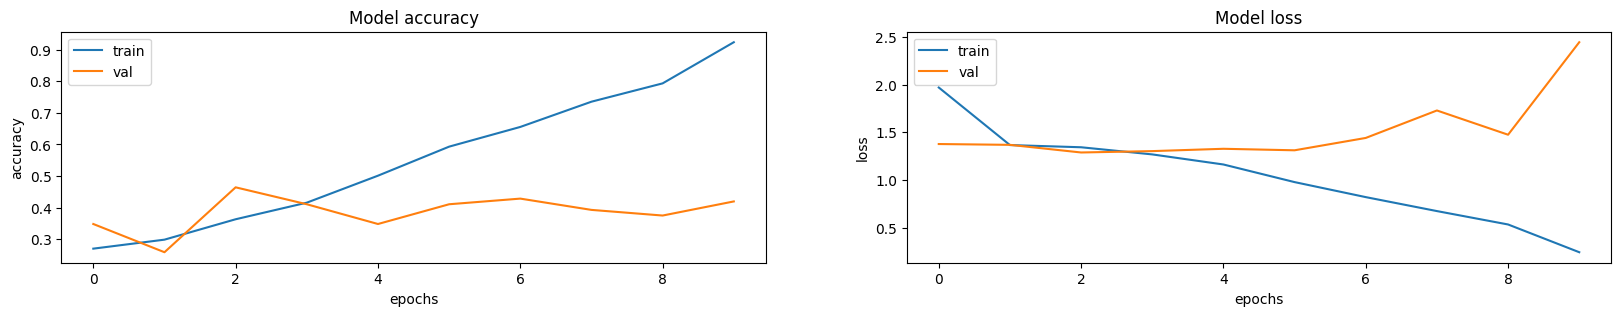

In [48]:
model =fonc_training(train_sequence_aug)

10/10 [==============================] - 21s 2s/step
Precision 0.3391194011684518
Recall 0.3516961299569995
f1_score 0.31538739685601913


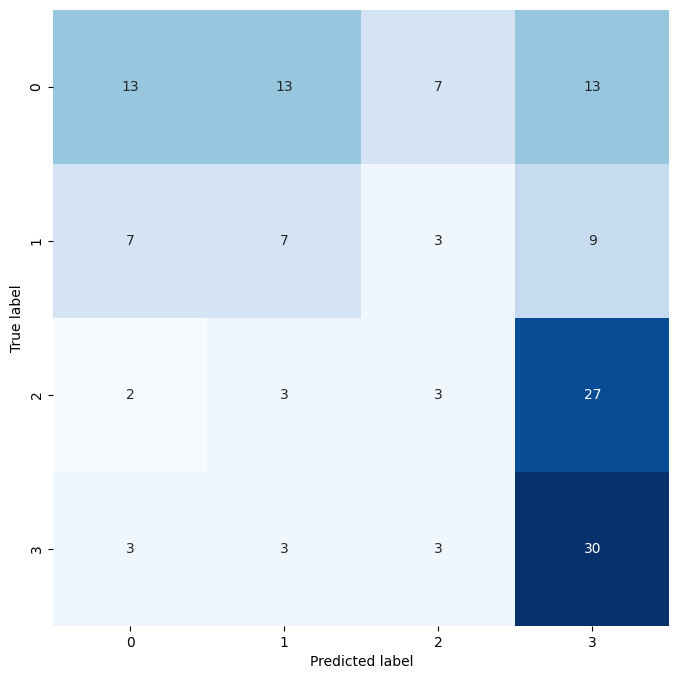

In [49]:
fonc_eval(model)

29/29 [==============================] - 71s 2s/step
Precision 0.9587108013937282
Recall 0.9547486894850448
f1_score 0.9534668388629219


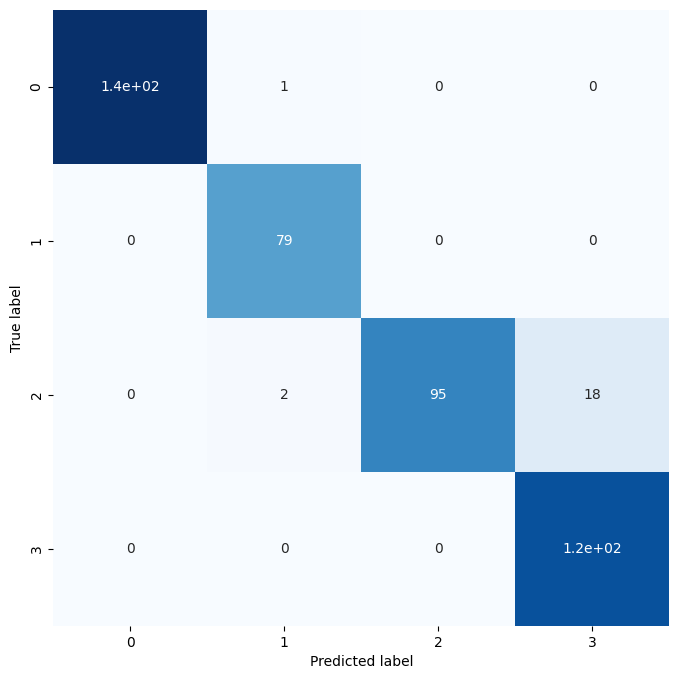

In [50]:
fonc_predict_train(model)

### Shift intensity

In [51]:
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['shiftIntensity'])

In [52]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: (16, 4)


Input shape: (40, 40, 80, 1)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_12 (Conv3D)          (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization_3 (Batc  (None, 40, 40, 80, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_15 (Activation)  (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_13 (Conv3D)          (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_16 (Activation)  (None, 40, 40, 80, 8)     0         
                              

/home/priscilla/.local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/10
58/58 [==============================] - ETA: 0s - loss: 1.9794 - accuracy: 0.2593
Epoch 1: val_accuracy improved from -inf to 0.34821, saving model to classifcier3D-imb-dataAug-01-0.35.hdf5
58/58 [==============================] - 98s 2s/step - loss: 1.9794 - accuracy: 0.2593 - val_loss: 1.3761 - val_accuracy: 0.3482
Epoch 2/10
58/58 [==============================] - ETA: 0s - loss: 1.3703 - accuracy: 0.3085
Epoch 2: val_accuracy did not improve from 0.34821
58/58 [==============================] - 95s 2s/step - loss: 1.3703 - accuracy: 0.3085 - val_loss: 1.3540 - val_accuracy: 0.3482
Epoch 3/10
58/58 [==============================] - ETA: 0s - loss: 1.3535 - accuracy: 0.3742
Epoch 3: val_accuracy improved from 0.34821 to 0.37500, saving model to classifcier3D-imb-dataAug-03-0.38.hdf5
58/58 [==============================] - 89s 2s/step - loss: 1.3535 - accuracy: 0.3742 - val_loss: 1.3587 - val_accuracy: 0.3750
Epoch 4/10
58/58 [==============================] - ETA: 0s -

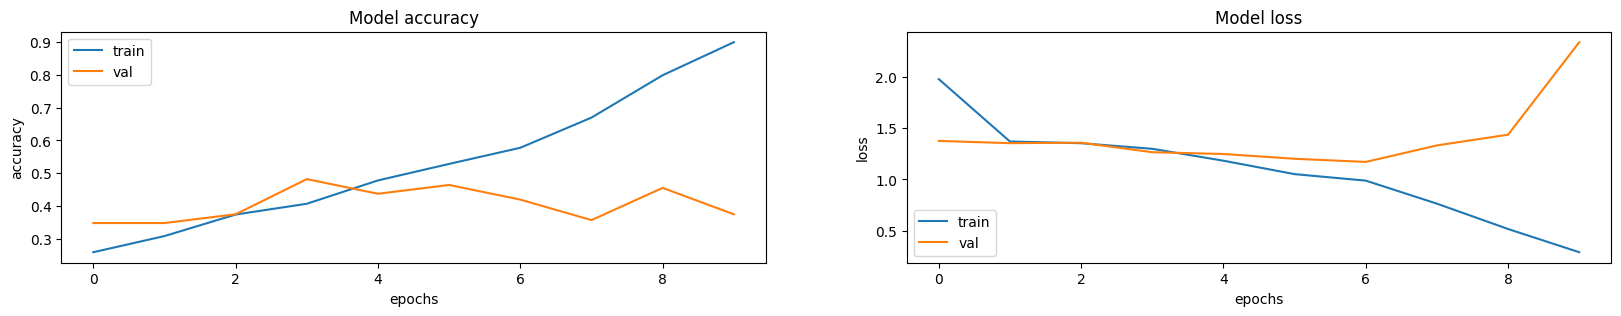

In [53]:
model =fonc_training(train_sequence_aug)

10/10 [==============================] - 21s 2s/step
Precision 0.39744380183326056
Recall 0.3574852683548335
f1_score 0.3159893151418575


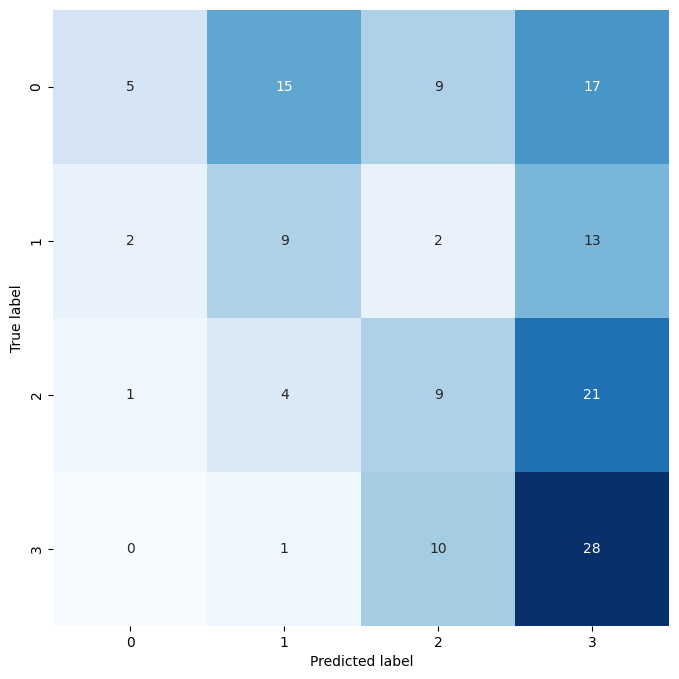

In [54]:
fonc_eval(model)

29/29 [==============================] - 69s 2s/step
Precision 0.8942680216979282
Recall 0.9061169724860166
f1_score 0.8912690581464404


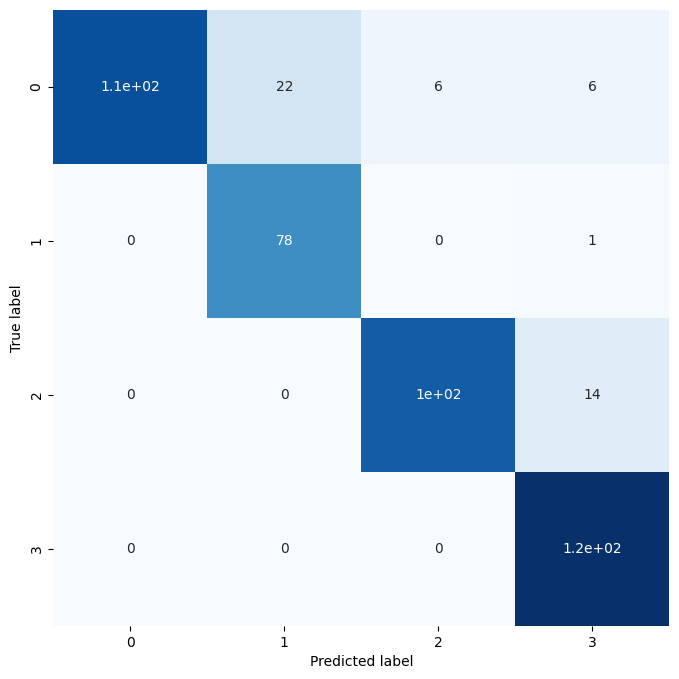

In [55]:
fonc_predict_train(model)

### Adjuste contrast

In [56]:
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['adjustContrast'])

In [57]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: (16, 4)


Input shape: (40, 40, 80, 1)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_16 (Conv3D)          (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization_4 (Batc  (None, 40, 40, 80, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_20 (Activation)  (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_17 (Conv3D)          (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_21 (Activation)  (None, 40, 40, 80, 8)     0         
                              

/home/priscilla/.local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/10
58/58 [==============================] - ETA: 0s - loss: 1.5190 - accuracy: 0.2670
Epoch 1: val_accuracy improved from -inf to 0.34821, saving model to classifcier3D-imb-dataAug-01-0.35.hdf5
58/58 [==============================] - 102s 2s/step - loss: 1.5190 - accuracy: 0.2670 - val_loss: 1.3830 - val_accuracy: 0.3482
Epoch 2/10
58/58 [==============================] - ETA: 0s - loss: 1.3804 - accuracy: 0.3151
Epoch 2: val_accuracy did not improve from 0.34821
58/58 [==============================] - 87s 1s/step - loss: 1.3804 - accuracy: 0.3151 - val_loss: 1.3754 - val_accuracy: 0.3482
Epoch 3/10
58/58 [==============================] - ETA: 0s - loss: 1.3636 - accuracy: 0.3085
Epoch 3: val_accuracy did not improve from 0.34821
58/58 [==============================] - 93s 2s/step - loss: 1.3636 - accuracy: 0.3085 - val_loss: 1.3571 - val_accuracy: 0.3482
Epoch 4/10
58/58 [==============================] - ETA: 0s - loss: 1.3422 - accuracy: 0.3698
Epoch 4: val_accuracy impr

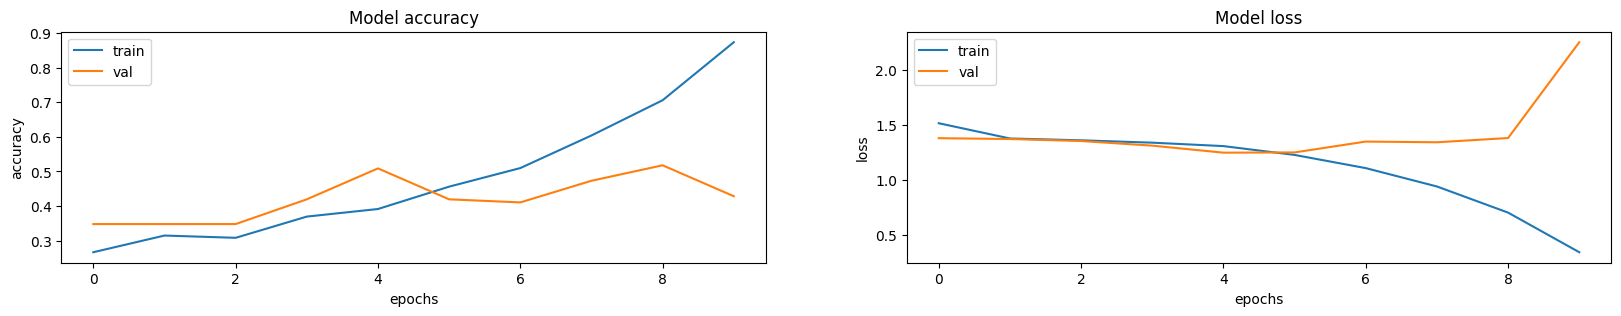

In [58]:
model =fonc_training(train_sequence_aug)

10/10 [==============================] - 21s 2s/step
Precision 0.3219260838663824
Recall 0.3151656314699793
f1_score 0.30298301285087303


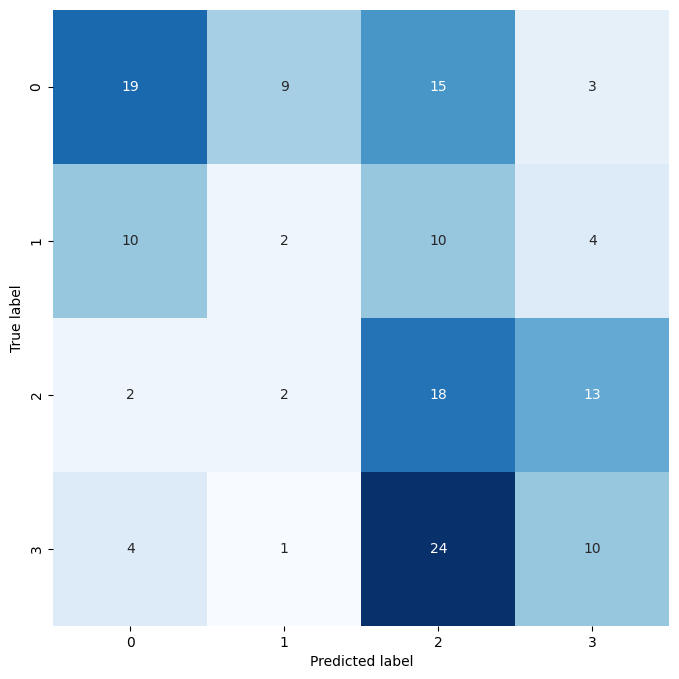

In [59]:
fonc_eval(model)

29/29 [==============================] - 70s 2s/step
Precision 0.9759816207184628
Recall 0.9734552134797396
f1_score 0.9739011833588436


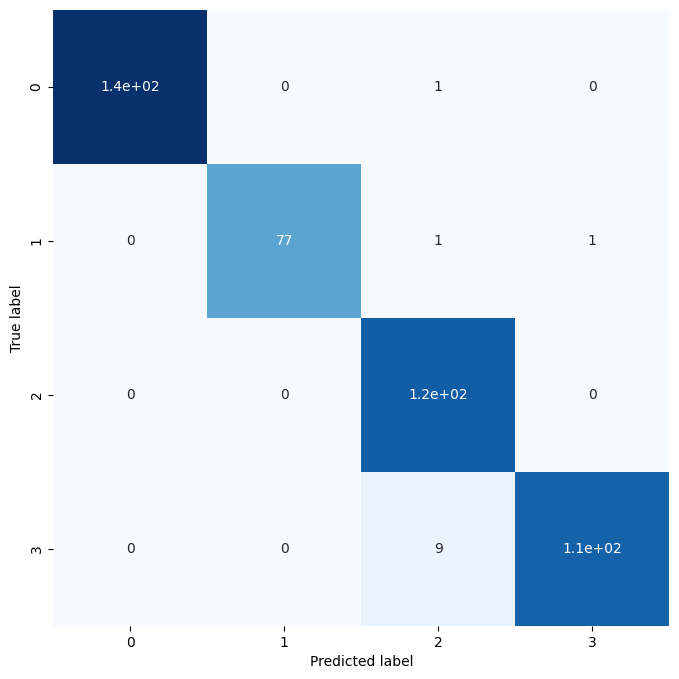

In [60]:
fonc_predict_train(model)

### RandBiasField

In [7]:
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['randBiasField'])

In [8]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: (16, 4)


Input shape: (40, 40, 80, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization (BatchN  (None, 40, 40, 80, 8)    32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_1 (Activation)   (None, 40, 40, 80, 8)     0         
                                

/home/priscilla/.local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/10
58/58 [==============================] - ETA: 0s - loss: 2.0906 - accuracy: 0.2987
Epoch 1: val_accuracy improved from -inf to 0.34821, saving model to classifcier3D-imb-dataAug-01-0.35.hdf5
58/58 [==============================] - 96s 2s/step - loss: 2.0906 - accuracy: 0.2987 - val_loss: 1.3768 - val_accuracy: 0.3482
Epoch 2/10
58/58 [==============================] - ETA: 0s - loss: 1.3721 - accuracy: 0.3085
Epoch 2: val_accuracy did not improve from 0.34821
58/58 [==============================] - 92s 2s/step - loss: 1.3721 - accuracy: 0.3085 - val_loss: 1.3678 - val_accuracy: 0.3482
Epoch 3/10
58/58 [==============================] - ETA: 0s - loss: 1.3715 - accuracy: 0.3085
Epoch 3: val_accuracy did not improve from 0.34821
58/58 [==============================] - 95s 2s/step - loss: 1.3715 - accuracy: 0.3085 - val_loss: 1.3685 - val_accuracy: 0.3482
Epoch 4/10
58/58 [==============================] - ETA: 0s - loss: 1.3666 - accuracy: 0.3085
Epoch 4: val_accuracy impro

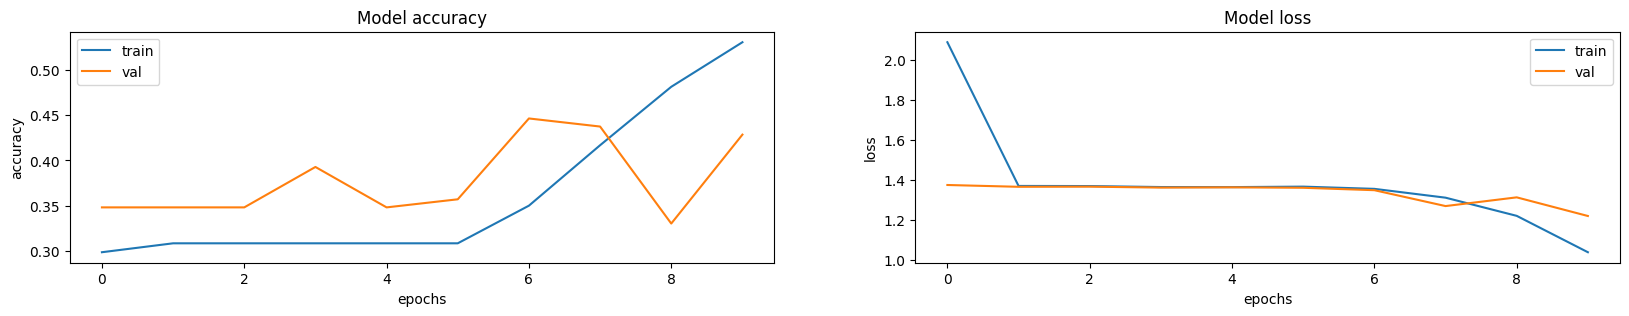

In [16]:
model =fonc_training(train_sequence_aug)

10/10 [==============================] - 22s 2s/step
Precision 0.29747474747474745
Recall 0.3612040133779264
f1_score 0.3229716520039101


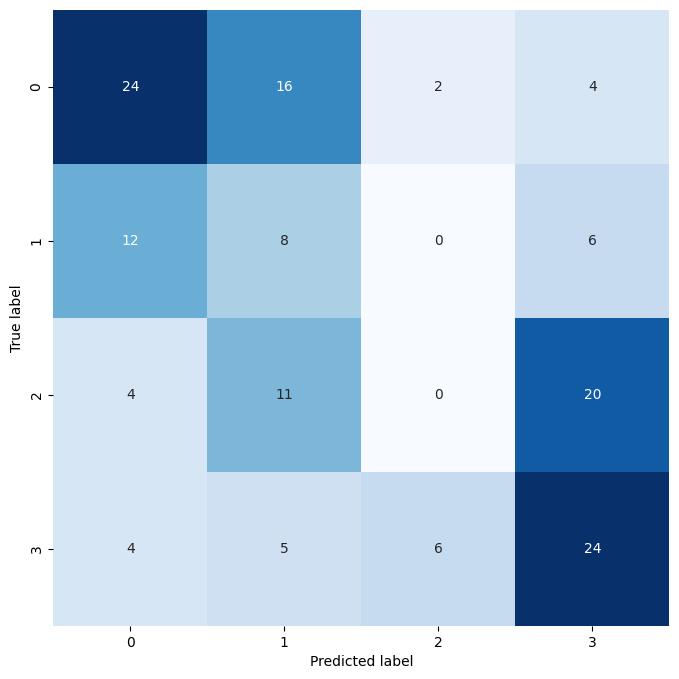

In [17]:
fonc_eval(model)

29/29 [==============================] - 73s 3s/step
Precision 0.7497273181315488
Recall 0.718369009964604
f1_score 0.7032353700109735


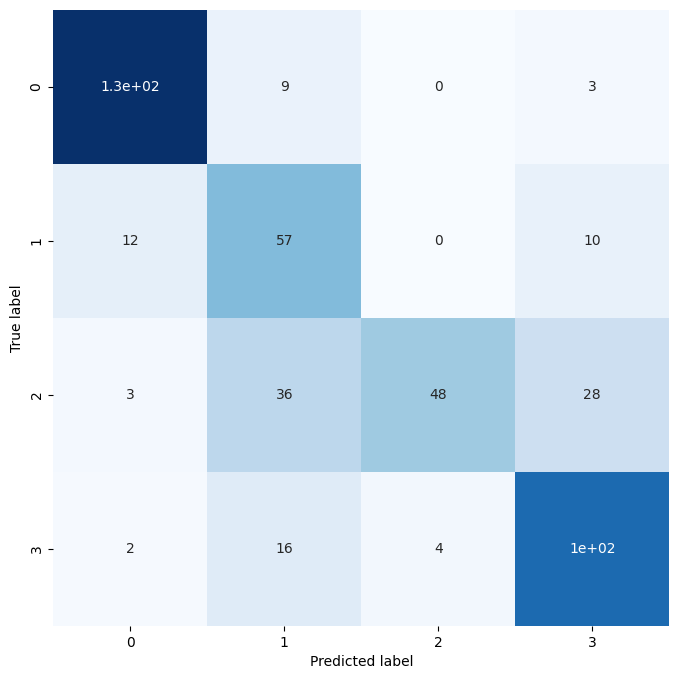

In [18]:
fonc_predict_train(model)

### rand3DElastic

In [ ]:
# train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['rand3DElastic'])

In [ ]:
# print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
# print("Train label example after loading:", train_sequence_aug[0][1].shape)

In [ ]:
# model =fonc_training(train_sequence_aug)

In [ ]:
# fonc_eval(model)

In [ ]:
# fonc_predict_train(model)